发现训练数据中有 445 个负值，将它们转换为零。
发现测试数据中有 138 个负值，将它们转换为零。
创建不同预测时长的训练数据...
输入窗口大小: 96 点
15分钟预测数据形状: X=(6902, 96), y=(6902, 1)
1小时预测数据形状: X=(6899, 96), y=(6899, 1)
4小时预测数据形状: X=(6887, 96), y=(6887, 1)

数据分割情况:
15分钟预测 - 训练集: (5521, 96), 验证集: (1381, 96)
1小时预测 - 训练集: (5519, 96), 验证集: (1380, 96)
4小时预测 - 训练集: (5509, 96), 验证集: (1378, 96)
训练集使用前80%数据，验证集使用后20%数据，保持原始数据顺序

模型参数设置:
15分钟预测模型: 隐藏层大小=16, 批量大小=64, 学习率=0.01
1小时预测模型: 隐藏层大小=64, 批量大小=64, 学习率=0.01
4小时预测模型: 隐藏层大小=128, 批量大小=128, 学习率=0.005

训练15分钟预测模型...
轮次 1/10000, 训练损失: 0.026842, 验证损失: 0.006189, CR指标: 68.7739%

早停触发！在第 194 轮停止训练
最佳CR指标: 83.9560%

训练1小时预测模型...

早停触发！在第 194 轮停止训练
最佳CR指标: 83.9560%

训练1小时预测模型...
轮次 1/10000, 训练损失: 0.039934, 验证损失: 0.009824, CR指标: 60.0391%
轮次 1/10000, 训练损失: 0.039934, 验证损失: 0.009824, CR指标: 60.0391%

早停触发！在第 66 轮停止训练
最佳CR指标: 68.9969%

训练4小时预测模型...
轮次 1/10000, 训练损失: 0.039526, 验证损失: 0.016099, CR指标: 54.4195%

早停触发！在第 66 轮停止训练
最佳CR指标: 68.9969%

训练4小时预测模型...
轮次 1/10000, 训练损失: 0.039526, 验证损失: 0.016099, CR指标: 54.4195%

早停触发！在第

2.795267105102539e-05

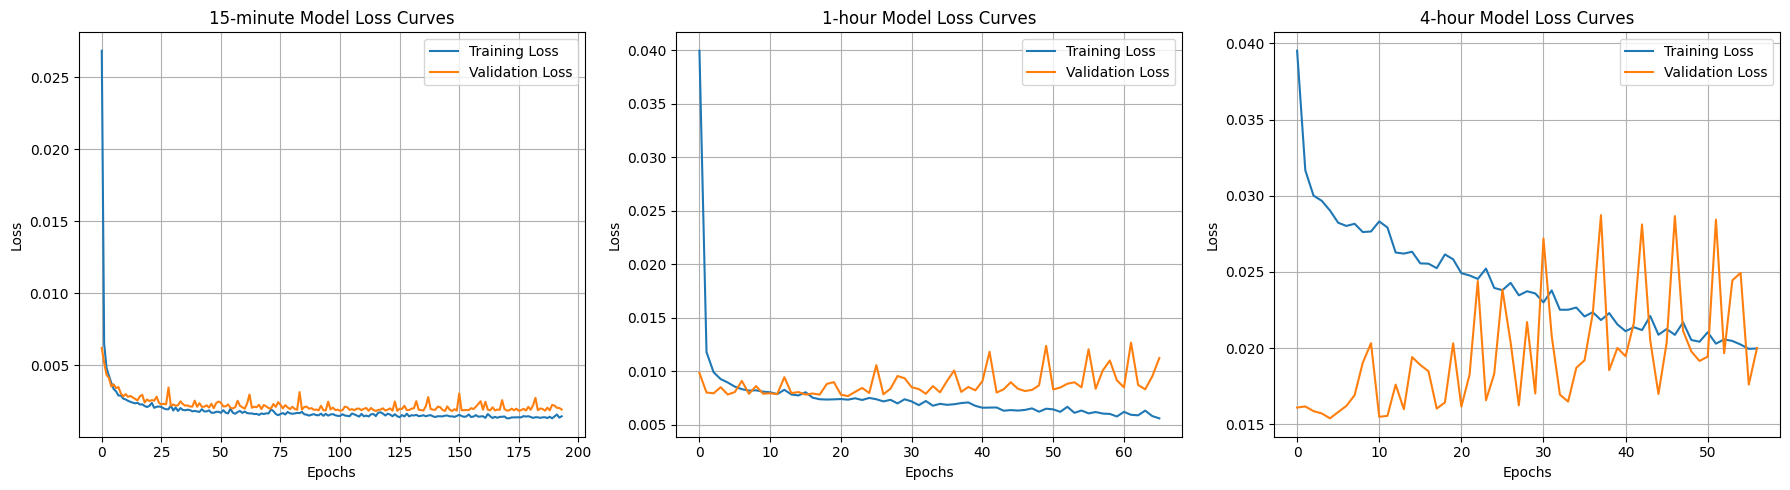

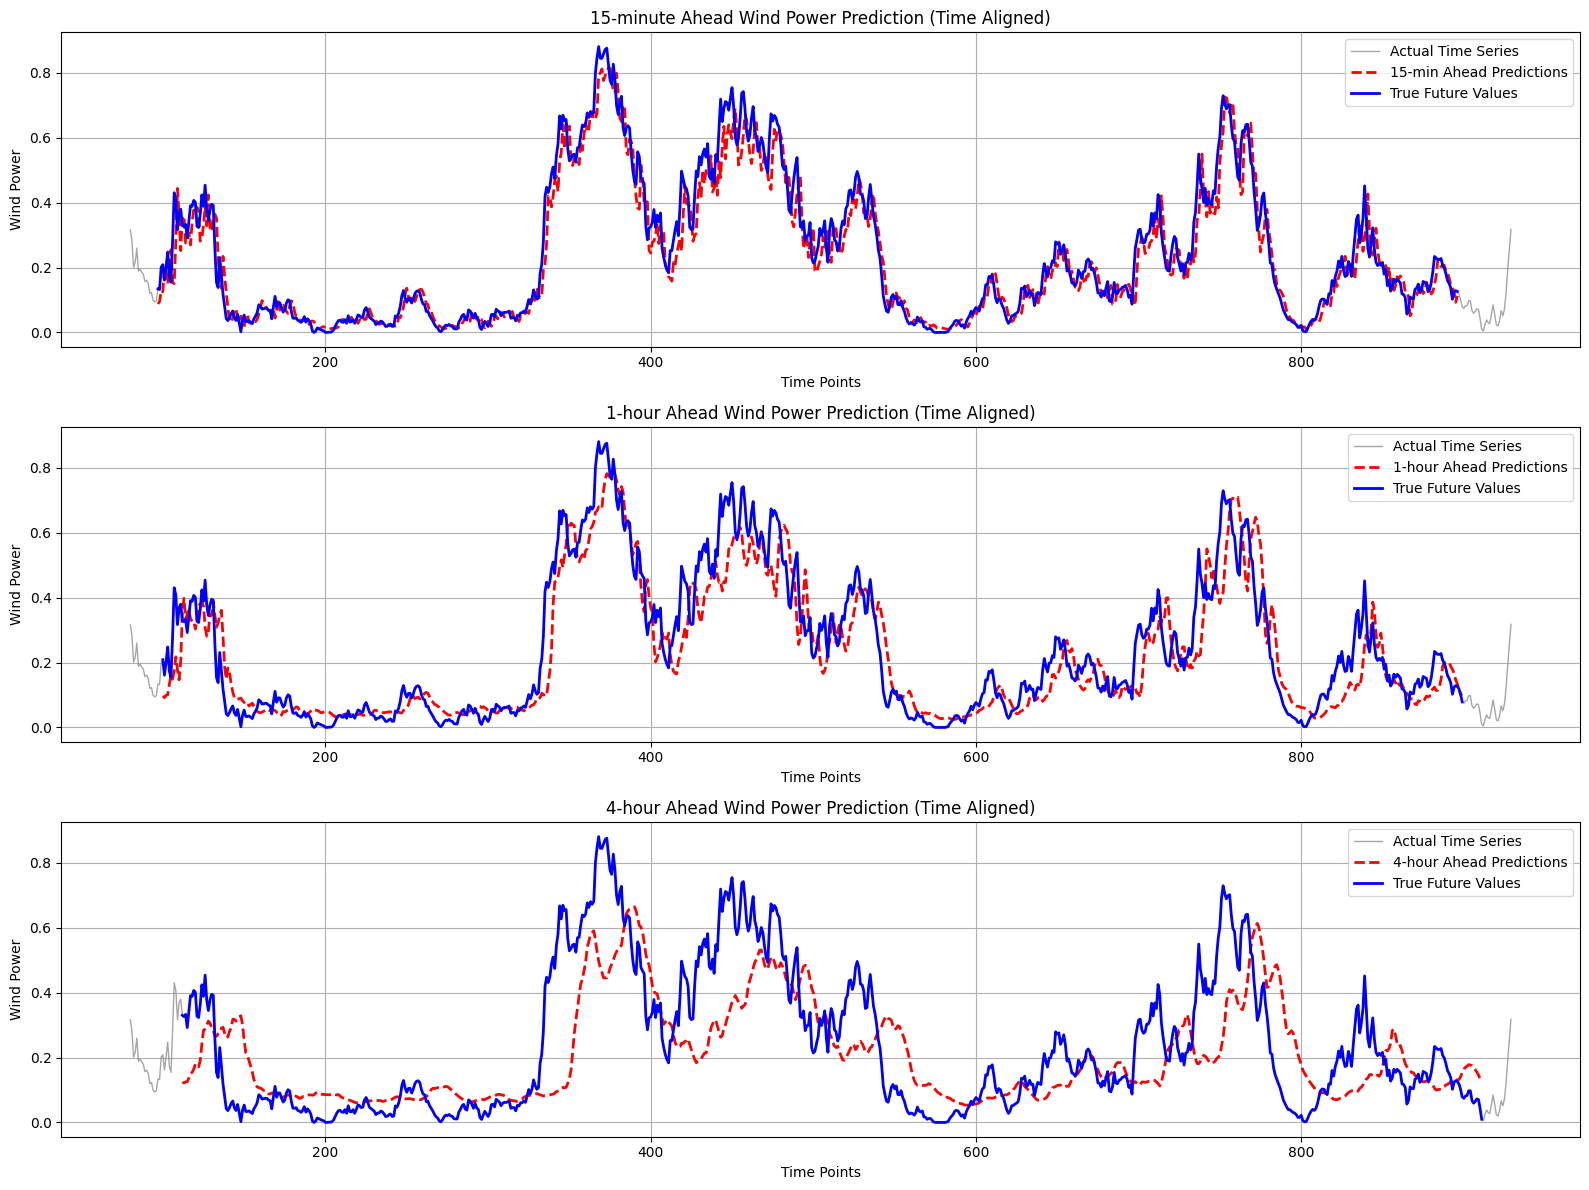

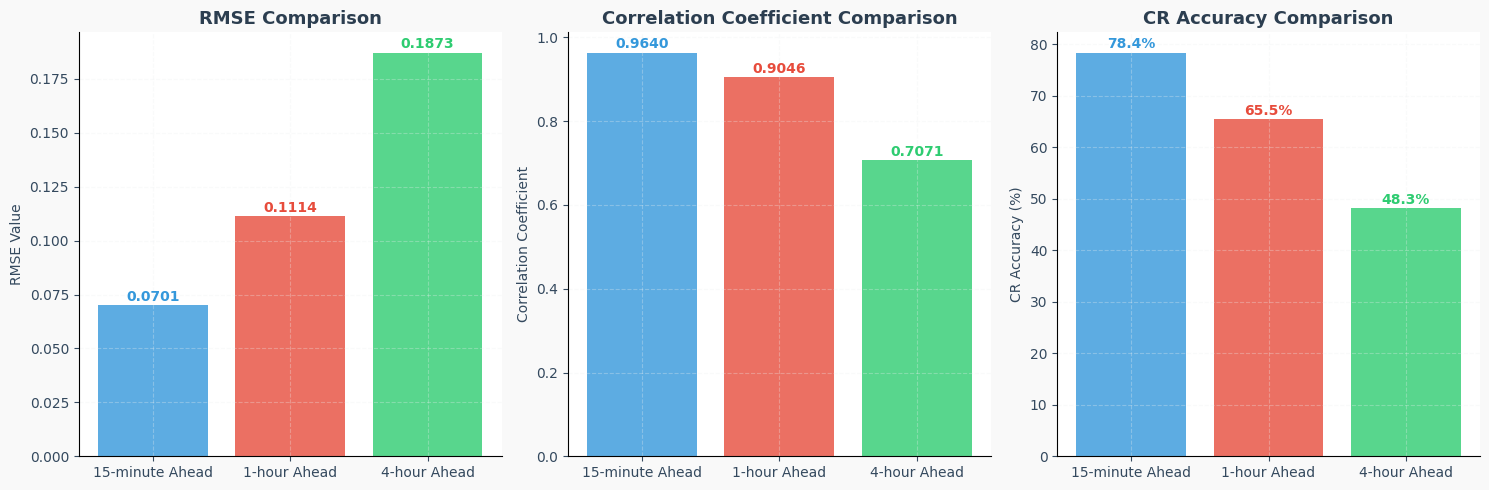

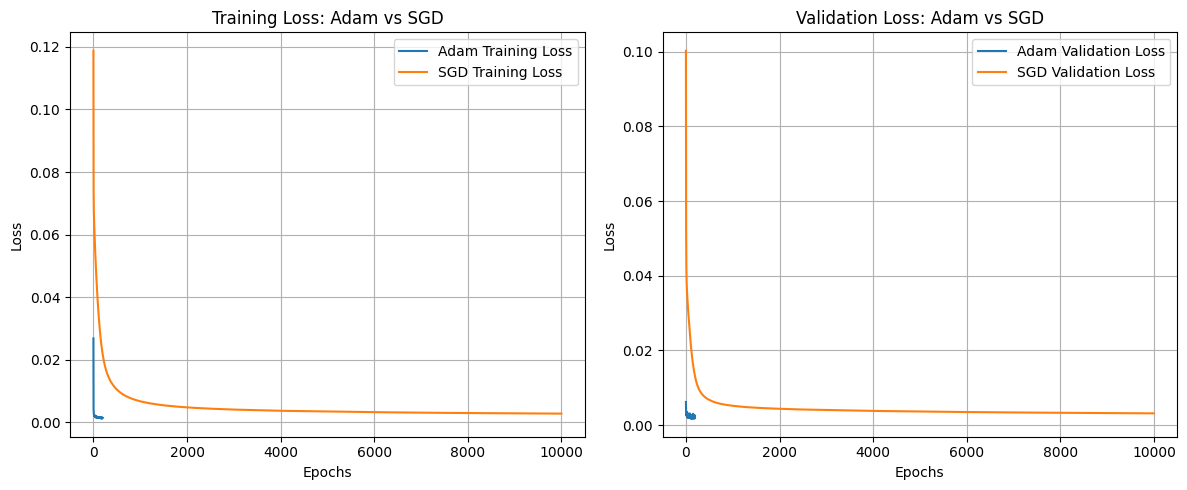

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# 设置随机种子以确保结果可重现
np.random.seed(42)

# 加载训练和测试数据
train_data = pd.read_excel('../data/train.xlsx')
test_data = pd.read_excel('../data/test.xlsx')

# 提取功率数据（第一列是实际功率 - 已归一化）
train_power = train_data.iloc[:, 0].values
test_power = test_data.iloc[:, 0].values

# 检查并清理训练数据中的负值
negative_count_train = np.sum(train_power < 0)
if negative_count_train > 0:
    print(f"发现训练数据中有 {negative_count_train} 个负值，将它们转换为零。")
    train_power = np.maximum(train_power, 0)  # 使用numpy的maximum函数将所有负值替换为0

# 检查并清理测试数据中的负值
negative_count_test = np.sum(test_power < 0)
if negative_count_test > 0:
    print(f"发现测试数据中有 {negative_count_test} 个负值，将它们转换为零。")
    test_power = np.maximum(test_power, 0)  # 使用numpy的maximum函数将所有负值替换为0
 

train_power_scaled = train_power
test_power_scaled = test_power

# CR指标计算函数
def calculate_CR(PM, PP):
    """
    计算CR指标（准确度指标）
    
    参数:
    PM: 实际值数组
    PP: 预测值数组
    
    返回:
    CR: CR指标值（百分比）
    """
    N = len(PM)
    Ri = np.zeros(N)
    for i in range(N):
        if PM[i] > 0.2:
            Ri[i] = (PM[i] - PP[i]) / PM[i]
        else:
            Ri[i] = (PM[i] - PP[i]) / 0.2
    rms_error = np.sqrt(np.mean(Ri**2))
    CR = (1 - rms_error) * 100
    return CR

# 准备训练数据：为3个不同预测时长创建数据集
def create_dataset_for_horizon(data, input_size=96, predict_horizon=1, step=1):
    """
    为特定预测时长创建训练数据集
    
    参数:
    data: 时间序列数据
    input_size: 输入窗口大小
    predict_horizon: 预测时长（1=15分钟, 4=1小时, 16=4小时）
    step: 滑动窗口步长
    
    返回:
    X: 输入序列，形状 (样本数量, 输入长度)
    y: 输出值，形状 (样本数量, 1)
    """
    X, y = [], []
    for i in range(0, len(data) - input_size - predict_horizon, step):
        X.append(data[i:i+input_size])
        y.append(data[i+input_size+predict_horizon-1])
    return np.array(X), np.array(y).reshape(-1, 1)

# 设置参数
input_size = 96
step = 1        

# 为3个不同时长创建训练数据
print("创建不同预测时长的训练数据...")
X_train_15min, y_train_15min = create_dataset_for_horizon(train_power_scaled, input_size, 1, step)
X_train_1hour, y_train_1hour = create_dataset_for_horizon(train_power_scaled, input_size, 4, step)
X_train_4hour, y_train_4hour = create_dataset_for_horizon(train_power_scaled, input_size, 16, step)

print(f"输入窗口大小: {input_size} 点")
print(f"15分钟预测数据形状: X={X_train_15min.shape}, y={y_train_15min.shape}")
print(f"1小时预测数据形状: X={X_train_1hour.shape}, y={y_train_1hour.shape}")
print(f"4小时预测数据形状: X={X_train_4hour.shape}, y={y_train_4hour.shape}")

# 分割训练和验证集
def split_train_val(X, y, train_ratio=0.8):
    # 按照顺序分割数据, 前80%用于训练，后20%用于验证
    train_size = int(len(X) * train_ratio)
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_val = X[train_size:]
    y_val = y[train_size:]
    return X_train, y_train, X_val, y_val

# 为每个预测时长分割数据
X_train_15min_split, y_train_15min_split, X_val_15min, y_val_15min = split_train_val(X_train_15min, y_train_15min)
X_train_1hour_split, y_train_1hour_split, X_val_1hour, y_val_1hour = split_train_val(X_train_1hour, y_train_1hour)
X_train_4hour_split, y_train_4hour_split, X_val_4hour, y_val_4hour = split_train_val(X_train_4hour, y_train_4hour)

print("\n数据分割情况:")
print(f"15分钟预测 - 训练集: {X_train_15min_split.shape}, 验证集: {X_val_15min.shape}")
print(f"1小时预测 - 训练集: {X_train_1hour_split.shape}, 验证集: {X_val_1hour.shape}")
print(f"4小时预测 - 训练集: {X_train_4hour_split.shape}, 验证集: {X_val_4hour.shape}")
print("训练集使用前80%数据，验证集使用后20%数据，保持原始数据顺序")

# 带多重防过拟合机制的BP神经网络类
class BPNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size=1, learning_rate=0.01, use_adam=True):
        """
        初始化BP神经网络
        
        参数:
        input_size: 输入层节点数
        hidden_size: 隐藏层节点数
        output_size: 输出层节点数（默认为1）
        learning_rate: 学习率
        use_adam: 是否使用Adam优化器
        """
        # 网络结构参数
        self.input_size = input_size    # 输入层节点数
        self.hidden_size = hidden_size  # 隐藏层节点数
        self.output_size = output_size  # 输出层节点数
        self.learning_rate = learning_rate  # 学习率
        self.use_adam = use_adam  # 是否使用Adam优化器
        
        # 初始化网络权重和偏置
        # Xavier初始化
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1/input_size)  # Xavier初始化
        self.b1 = np.zeros((1, hidden_size))  # 隐藏层偏置
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1/hidden_size)  # Xavier初始化
        self.b2 = np.zeros((1, output_size))  # 输出层偏置
        
        # Adam优化器参数
        if use_adam:
            # 动量参数
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.epsilon = 1e-8
            
            # 初始化梯度动量和平方梯度动量
            self.m_W1 = np.zeros_like(self.W1)
            self.m_b1 = np.zeros_like(self.b1)
            self.m_W2 = np.zeros_like(self.W2)
            self.m_b2 = np.zeros_like(self.b2)
            
            self.v_W1 = np.zeros_like(self.W1)
            self.v_b1 = np.zeros_like(self.b1)
            self.v_W2 = np.zeros_like(self.W2)
            self.v_b2 = np.zeros_like(self.b2)
            
            # 时间步计数器
            self.t = 0
    
    def sigmoid(self, x):
        """
        Sigmoid激活函数: f(x) = 1 / (1 + e^(-x))
        将输入映射到(0,1)范围，适用于隐藏层和输出层
        """
        # 防止数值溢出
        x = np.clip(x, -500, 500)
        return 1.0 / (1.0 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        """
        Sigmoid函数导数: f'(x) = f(x) * (1 - f(x))
        用于反向传播梯度计算
        """
        return x * (1.0 - x)
    
    def forward(self, X):
        """
        前向传播算法
        
        参数:
        X: 输入数据，形状 (样本数量, 输入维度)
        
        返回:
        输出层输出
        """
        # 第一层：输入层到隐藏层
        self.z1 = np.dot(X, self.W1) + self.b1  # 隐藏层加权输入
        
        # 使用Sigmoid激活函数（隐藏层）
        self.a1 = self.sigmoid(self.z1)
        
        # 第二层：隐藏层到输出层
        self.z2 = np.dot(self.a1, self.W2) + self.b2  # 输出层加权输入
        self.a2 = self.sigmoid(self.z2)  # 输出层使用sigmoid激活
        
        return self.a2
    
    def backward(self, X, y, output):
        """
        反向传播算法（不包含正则化）
        
        参数:
        X: 输入数据，形状 (样本数量, 输入维度)
        y: 目标输出，形状 (样本数量, 输出维度)
        output: 前向传播输出
        
        返回:
        当前批次误差
        """
        # 计算输出层误差
        output_error = y - output  # 输出误差
        output_delta = output_error * self.sigmoid_derivative(output)  # 输出层梯度
        
        # 计算隐藏层误差
        hidden_error = np.dot(output_delta, self.W2.T)  # 通过链式法则计算隐藏层误差
        # 使用sigmoid的导数
        hidden_delta = hidden_error * self.sigmoid_derivative(self.a1)
        
        # 更新权重和偏置
        m = X.shape[0]  # 样本数量
        
        # 计算梯度
        dW2 = np.dot(self.a1.T, output_delta) / m
        db2 = np.sum(output_delta, axis=0, keepdims=True) / m
        dW1 = np.dot(X.T, hidden_delta) / m
        db1 = np.sum(hidden_delta, axis=0, keepdims=True) / m
        
        if self.use_adam:
            # Adam优化器更新
            self.t += 1
            
            # 更新动量
            self.m_W2 = self.beta1 * self.m_W2 + (1 - self.beta1) * dW2
            self.m_b2 = self.beta1 * self.m_b2 + (1 - self.beta1) * db2
            self.m_W1 = self.beta1 * self.m_W1 + (1 - self.beta1) * dW1
            self.m_b1 = self.beta1 * self.m_b1 + (1 - self.beta1) * db1
            
            # 更新平方梯度动量
            self.v_W2 = self.beta2 * self.v_W2 + (1 - self.beta2) * (dW2 ** 2)
            self.v_b2 = self.beta2 * self.v_b2 + (1 - self.beta2) * (db2 ** 2)
            self.v_W1 = self.beta2 * self.v_W1 + (1 - self.beta2) * (dW1 ** 2)
            self.v_b1 = self.beta2 * self.v_b1 + (1 - self.beta2) * (db1 ** 2)
            
            # 偏置校正
            m_W2_corrected = self.m_W2 / (1 - self.beta1 ** self.t)
            m_b2_corrected = self.m_b2 / (1 - self.beta1 ** self.t)
            m_W1_corrected = self.m_W1 / (1 - self.beta1 ** self.t)
            m_b1_corrected = self.m_b1 / (1 - self.beta1 ** self.t)
            
            v_W2_corrected = self.v_W2 / (1 - self.beta2 ** self.t)
            v_b2_corrected = self.v_b2 / (1 - self.beta2 ** self.t)
            v_W1_corrected = self.v_W1 / (1 - self.beta2 ** self.t)
            v_b1_corrected = self.v_b1 / (1 - self.beta2 ** self.t)
            
            # 使用Adam更新规则更新权重
            self.W2 += self.learning_rate * m_W2_corrected / (np.sqrt(v_W2_corrected) + self.epsilon)
            self.b2 += self.learning_rate * m_b2_corrected / (np.sqrt(v_b2_corrected) + self.epsilon)
            self.W1 += self.learning_rate * m_W1_corrected / (np.sqrt(v_W1_corrected) + self.epsilon)
            self.b1 += self.learning_rate * m_b1_corrected / (np.sqrt(v_b1_corrected) + self.epsilon)
        else:
            # 使用传统梯度下降更新权重
            self.W2 += self.learning_rate * dW2
            self.b2 += self.learning_rate * db2
            self.W1 += self.learning_rate * dW1
            self.b1 += self.learning_rate * db1
        
        # 计算总误差（均方误差）- 不再包含正则化项
        mse = np.mean(np.sum(np.square(output_error), axis=1))
        return mse
    
    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100, batch_size=32, 
              shuffle=True, verbose=True, early_stopping=True, patience=200, min_delta=1e-6):

        train_losses = []  
        val_losses = []   
        val_cr_scores = [] 
        n_samples = X_train.shape[0]  
        
        # 早停相关变量
        best_cr_score = -np.inf  # 最佳CR指标（越高越好）
        patience_counter = 0     
        best_weights = None      
        
        for epoch in range(epochs):
            if shuffle:
                # 打乱数据以获得更稳定和鲁棒的训练
                indices = np.random.permutation(n_samples)
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]
            else:
                X_shuffled = X_train
                y_shuffled = y_train
            
            epoch_loss = 0
            # 每次用batch_size个样本更新权重
            for i in range(0, n_samples, batch_size):
                end = min(i + batch_size, n_samples)
                batch_X = X_shuffled[i:end]
                batch_y = y_shuffled[i:end]
                
                # 前向传播
                output = self.forward(batch_X)
                
                # 反向传播和权重更新
                batch_loss = self.backward(batch_X, batch_y, output)
                epoch_loss += batch_loss * (end - i) / n_samples
            
            train_losses.append(epoch_loss)
            
            # 在验证集上评估（如果提供）
            if X_val is not None and y_val is not None:
                val_output = self.forward(X_val)
                val_loss = np.mean(np.sum(np.square(y_val - val_output), axis=1))
                val_losses.append(val_loss)
                
                # 计算CR指标
                val_predictions = val_output.flatten()
                val_actual = y_val.flatten()
                val_cr_score = calculate_CR(val_actual, val_predictions)
                val_cr_scores.append(val_cr_score)
                
                # 早停检查
                if early_stopping:
                    if val_cr_score > best_cr_score + min_delta:
                        best_cr_score = val_cr_score
                        patience_counter = 0
                        # 保存最佳权重
                        best_weights = {
                            'W1': self.W1.copy(),
                            'b1': self.b1.copy(), 
                            'W2': self.W2.copy(),
                            'b2': self.b2.copy()
                        }
                    else:
                        patience_counter += 1
                    
                    # 如果超过耐心值，停止训练
                    if patience_counter >= patience:
                        if verbose:
                            print(f"\n早停触发！在第 {epoch+1} 轮停止训练")
                            print(f"最佳CR指标: {best_cr_score:.4f}%")
                        # 恢复最佳权重
                        if best_weights:
                            self.W1 = best_weights['W1']
                            self.b1 = best_weights['b1']
                            self.W2 = best_weights['W2']
                            self.b2 = best_weights['b2']
                        break
                
                # 打印训练进度
                if verbose and (epoch % 200 == 0 or epoch == epochs - 1):
                    print(f"轮次 {epoch+1}/{epochs}, 训练损失: {epoch_loss:.6f}, 验证损失: {val_loss:.6f}, CR指标: {val_cr_score:.4f}%")
            else:
                # 打印训练进度
                if verbose and (epoch % 200 == 0 or epoch == epochs - 1):
                    print(f"轮次 {epoch+1}/{epochs}, 训练损失: {epoch_loss:.6f}")
        
        return train_losses, val_losses if X_val is not None else train_losses, val_cr_scores if X_val is not None else []
    
    def predict(self, X):
        """
        预测函数
        
        参数:
        X: 输入数据
        
        返回:
        预测结果
        """
        return self.forward(X)

# 设置共享模型参数
max_epochs = 10000     

# 为三个不同的预测模型设置不同的参数
# 15分钟预测模型参数
hidden_size_15min = 16 
batch_size_15min = 64   
learning_rate_15min = 0.01   

# 1小时预测模型参数
hidden_size_1hour = 64 
batch_size_1hour = 64   
learning_rate_1hour = 0.01 

# 4小时预测模型参数
hidden_size_4hour = 128   
batch_size_4hour = 128 
learning_rate_4hour = 0.005

print(f"\n模型参数设置:")
print(f"15分钟预测模型: 隐藏层大小={hidden_size_15min}, 批量大小={batch_size_15min}, 学习率={learning_rate_15min}")
print(f"1小时预测模型: 隐藏层大小={hidden_size_1hour}, 批量大小={batch_size_1hour}, 学习率={learning_rate_1hour}")
print(f"4小时预测模型: 隐藏层大小={hidden_size_4hour}, 批量大小={batch_size_4hour}, 学习率={learning_rate_4hour}")

# 早停参数
patience = 50         
min_delta = 0.0005       

# 创建并训练3个独立的BP神经网络

print("\n训练15分钟预测模型...")
model_15min = BPNeuralNetwork(input_size, hidden_size_15min, 1, learning_rate_15min, use_adam=True)
train_losses_15min, val_losses_15min, val_cr_scores_15min = model_15min.train(
    X_train_15min_split, y_train_15min_split, 
    X_val_15min, y_val_15min, 
    max_epochs, batch_size_15min, shuffle=True,
    early_stopping=True, patience=patience, min_delta=min_delta
)

print("\n训练1小时预测模型...")
model_1hour = BPNeuralNetwork(input_size, hidden_size_1hour, 1, learning_rate_1hour, use_adam=True)
train_losses_1hour, val_losses_1hour, val_cr_scores_1hour = model_1hour.train(
    X_train_1hour_split, y_train_1hour_split, 
    X_val_1hour, y_val_1hour, 
    max_epochs, batch_size_1hour, shuffle=True,
    early_stopping=True, patience=patience, min_delta=min_delta
)

print("\n训练4小时预测模型...")
model_4hour = BPNeuralNetwork(input_size, hidden_size_4hour, 1, learning_rate_4hour, use_adam=True)
train_losses_4hour, val_losses_4hour, val_cr_scores_4hour = model_4hour.train(
    X_train_4hour_split, y_train_4hour_split, 
    X_val_4hour, y_val_4hour, 
    max_epochs, batch_size_4hour, shuffle=True,
    early_stopping=True, patience=patience, min_delta=min_delta
)

# 绘制损失曲线
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(train_losses_15min, label='Training Loss')
axes[0].plot(val_losses_15min, label='Validation Loss')
axes[0].set_title('15-minute Model Loss Curves')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(train_losses_1hour, label='Training Loss')
axes[1].plot(val_losses_1hour, label='Validation Loss')
axes[1].set_title('1-hour Model Loss Curves')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(train_losses_4hour, label='Training Loss')
axes[2].plot(val_losses_4hour, label='Validation Loss')
axes[2].set_title('4-hour Model Loss Curves')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('figure/all_models_loss_curves.png', dpi=300, bbox_inches='tight')
print("\n所有模型的损失曲线已保存为 'figure/all_models_loss_curves.png'")



# 保存训练好的模型
print("\n保存模型到 models 文件夹...")

os.makedirs('models', exist_ok=True)

with open('models/model_15min.pkl', 'wb') as f:
    pickle.dump(model_15min, f)

with open('models/model_1hour.pkl', 'wb') as f:
    pickle.dump(model_1hour, f)

with open('models/model_4hour.pkl', 'wb') as f:
    pickle.dump(model_4hour, f)

print("模型保存完成！")


print("\n开始多点预测（从第96个点开始，步长=1）...")
print("预测时间点：15分钟后、1小时后、4小时后")

# 确定预测窗口
start_index = 96  # 测试预测的起始索引
hop_len = 1       # 步长为1，每个点都测试

# 计算最大可预测的样本数
max_predictions = len(test_power) - start_index - 16  # 确保4小时后的真实值存在

# 存储预测结果
predictions_15min = []
predictions_1hour = []
predictions_4hour = []

# 对应的真实值
actual_15min = []
actual_1hour = []
actual_4hour = []

print(f"最大可预测样本数: {max_predictions}")

# 逐点预测
for i in range(0, max_predictions, hop_len):
    target_idx = start_index + i  # 要预测的目标时间点
    
    # 15分钟预测
    if target_idx >= input_size:
        input_window_15min = test_power_scaled[target_idx-input_size:target_idx]
        input_window_15min_reshaped = input_window_15min.reshape(1, -1)
        pred_15min = model_15min.predict(input_window_15min_reshaped)[0, 0]
        predictions_15min.append(pred_15min)
        actual_15min.append(test_power[target_idx+1])
    
    # 1小时预测
    if target_idx >= input_size + 4:
        input_window_1hour = test_power_scaled[target_idx-input_size-4:target_idx-4]
        input_window_1hour_reshaped = input_window_1hour.reshape(1, -1)
        pred_1hour = model_1hour.predict(input_window_1hour_reshaped)[0, 0]
        predictions_1hour.append(pred_1hour)
        actual_1hour.append(test_power[target_idx])
    
    # 4小时预测
    if target_idx >= input_size + 16:
        input_window_4hour = test_power_scaled[target_idx-input_size-16:target_idx-16]
        input_window_4hour_reshaped = input_window_4hour.reshape(1, -1)
        pred_4hour = model_4hour.predict(input_window_4hour_reshaped)[0, 0]
        predictions_4hour.append(pred_4hour)
        actual_4hour.append(test_power[target_idx])

# 转换为numpy数组
predictions_15min = np.array(predictions_15min)
predictions_1hour = np.array(predictions_1hour)
predictions_4hour = np.array(predictions_4hour)
actual_15min = np.array(actual_15min)
actual_1hour = np.array(actual_1hour)
actual_4hour = np.array(actual_4hour)

print(f"实际预测样本数: 15分钟={len(predictions_15min)}, 1小时={len(predictions_1hour)}, 4小时={len(predictions_4hour)}")

# 计算各时间点的评估指标
def calculate_metrics(predictions, actual, time_label):
    """
    计算评估指标
    """
    # RMSE
    rmse = np.sqrt(np.mean((predictions - actual)**2))
    
    # 相关系数
    corr = np.corrcoef(predictions, actual)[0, 1]
    
    # CR指标
    cr_accuracy = calculate_CR(actual, predictions)
    
    print(f"\n{time_label} 预测结果:")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  相关系数: {corr:.6f}")
    print(f"  CR准确度指标: {cr_accuracy:.2f}%")
    
    return rmse, corr, cr_accuracy

# 计算各时间点的指标
metrics_15min = calculate_metrics(predictions_15min, actual_15min, "15分钟后")
metrics_1hour = calculate_metrics(predictions_1hour, actual_1hour, "1小时后")
metrics_4hour = calculate_metrics(predictions_4hour, actual_4hour, "4小时后")

error_15min = predictions_15min - actual_15min
error_1hour = predictions_1hour - actual_1hour
error_4hour = predictions_4hour - actual_4hour

# 将所有评估指标保存到CSV文件
print("\n保存评估指标到CSV文件...")
os.makedirs('results', exist_ok=True)

# 创建汇总评估指标的DataFrame
metrics_df = pd.DataFrame({
    '预测时间点': ['15分钟后', '1小时后', '4小时后'],
    'RMSE': [metrics_15min[0], metrics_1hour[0], metrics_4hour[0]],
    '相关系数': [metrics_15min[1], metrics_1hour[1], metrics_4hour[1]],
    'CR准确度(%)': [metrics_15min[2], metrics_1hour[2], metrics_4hour[2]]
})

# 保存汇总评估指标
metrics_df.to_csv('results/summary_metrics.csv', index=False, encoding='utf-8-sig')
print("汇总评估指标已保存到 'results/summary_metrics.csv'")

# 创建并保存15分钟预测的详细结果
detailed_15min_df = pd.DataFrame({
    '真实值': actual_15min,
    '预测值': predictions_15min,
    '误差': error_15min
})
detailed_15min_df.to_csv('results/detailed_15min_prediction.csv', index=False, encoding='utf-8-sig')
print("15分钟预测详细结果已保存到 'results/detailed_15min_prediction.csv'")

# 创建并保存1小时预测的详细结果
detailed_1hour_df = pd.DataFrame({
    '真实值': actual_1hour,
    '预测值': predictions_1hour,
    '误差': error_1hour
})
detailed_1hour_df.to_csv('results/detailed_1hour_prediction.csv', index=False, encoding='utf-8-sig')
print("1小时预测详细结果已保存到 'results/detailed_1hour_prediction.csv'")

# 创建并保存4小时预测的详细结果
detailed_4hour_df = pd.DataFrame({
    '真实值': actual_4hour,
    '预测值': predictions_4hour,
    '误差': error_4hour
})
detailed_4hour_df.to_csv('results/detailed_4hour_prediction.csv', index=False, encoding='utf-8-sig')
print("4小时预测详细结果已保存到 'results/detailed_4hour_prediction.csv'")


# 绘制多点预测对比图
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

plot_range = min(800, len(predictions_15min))

# 从测试集中获取一段连续的真实值作为背景
background_start = 80
background_length = plot_range + 50  # 足够长的背景序列

# 获取背景真实值
background_actual = test_power[background_start:background_start + background_length]
background_time = np.arange(background_start, background_start + len(background_actual))

# -------------------------------
# 1) 15分钟预测的时间对齐
# -------------------------------
axes[0].plot(background_time, background_actual, label='Actual Time Series', 
             linewidth=1, alpha=0.7, color='gray')
# 预测值在正确的未来时间点显示
pred_time_15min = np.arange(start_index + 1, start_index + 1 + plot_range)  # 96+1 开始
axes[0].plot(pred_time_15min, predictions_15min[:plot_range], 
             label='15-min Ahead Predictions', linestyle='--', linewidth=2, color='red')
axes[0].plot(pred_time_15min, actual_15min[:plot_range], 
             label='True Future Values', linewidth=2, color='blue')
axes[0].set_title('15-minute Ahead Wind Power Prediction (Time Aligned)')
axes[0].set_xlabel('Time Points')
axes[0].set_ylabel('Wind Power')
axes[0].legend()
axes[0].grid(True)

# -------------------------------
# 2) 1小时预测的时间对齐
# -------------------------------
axes[1].plot(background_time, background_actual, label='Actual Time Series', 
             linewidth=1, alpha=0.7, color='gray')
pred_time_1hour = np.arange(start_index + 4, start_index + 4 + plot_range)  # 96+4 开始
axes[1].plot(pred_time_1hour, predictions_1hour[:plot_range], 
             label='1-hour Ahead Predictions', linestyle='--', linewidth=2, color='red')
axes[1].plot(pred_time_1hour, actual_1hour[:plot_range], 
             label='True Future Values', linewidth=2, color='blue')
axes[1].set_title('1-hour Ahead Wind Power Prediction (Time Aligned)')
axes[1].set_xlabel('Time Points')
axes[1].set_ylabel('Wind Power')
axes[1].legend()
axes[1].grid(True)

# -------------------------------
# 3) 4小时预测的时间对齐
# -------------------------------
axes[2].plot(background_time, background_actual, label='Actual Time Series', 
             linewidth=1, alpha=0.7, color='gray')
pred_time_4hour = np.arange(start_index + 16, start_index + 16 + plot_range)  # 96+16 开始
axes[2].plot(pred_time_4hour, predictions_4hour[:plot_range], 
             label='4-hour Ahead Predictions', linestyle='--', linewidth=2, color='red')
axes[2].plot(pred_time_4hour, actual_4hour[:plot_range], 
             label='True Future Values', linewidth=2, color='blue')
axes[2].set_title('4-hour Ahead Wind Power Prediction (Time Aligned)')
axes[2].set_xlabel('Time Points')
axes[2].set_ylabel('Wind Power')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('figure/multi_point_predictions_time_aligned.png', dpi=300, bbox_inches='tight')
print("\n时间对齐的多点预测对比图已保存为 'figure/multi_point_predictions_time_aligned.png'")


# 绘制评估指标对比图
time_points = ['15-minute Ahead', '1-hour Ahead', '4-hour Ahead']
rmse_values = [metrics_15min[0], metrics_1hour[0], metrics_4hour[0]]
corr_values = [metrics_15min[1], metrics_1hour[1], metrics_4hour[1]]
cr_values = [metrics_15min[2], metrics_1hour[2], metrics_4hour[2]]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

color_palette = ['#3498db', '#e74c3c', '#2ecc71']  
title_color = '#2c3e50'  
grid_color = '#ecf0f1'  
text_color = '#34495e'  

# RMSE指标对比
axes[0].bar(time_points, rmse_values, color=color_palette, alpha=0.8)
axes[0].set_title('RMSE Comparison', fontsize=13, fontweight='bold', color=title_color)
axes[0].set_ylabel('RMSE Value', color=text_color)
axes[0].grid(True, alpha=0.3, color=grid_color, linestyle='--')
axes[0].spines['top'].set_visible(False)  
axes[0].spines['right'].set_visible(False) 
axes[0].tick_params(colors=text_color)
for i, v in enumerate(rmse_values):
    axes[0].text(i, v + max(rmse_values)*0.01, f'{v:.4f}', ha='center',
                fontweight='bold', color=color_palette[i])

# 相关系数对比
axes[1].bar(time_points, corr_values, color=color_palette, alpha=0.8)
axes[1].set_title('Correlation Coefficient Comparison', fontsize=13, fontweight='bold', color=title_color)
axes[1].set_ylabel('Correlation Coefficient', color=text_color)
axes[1].grid(True, alpha=0.3, color=grid_color, linestyle='--')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].tick_params(colors=text_color)
for i, v in enumerate(corr_values):
    axes[1].text(i, v + max(corr_values)*0.01, f'{v:.4f}', ha='center', 
                fontweight='bold', color=color_palette[i])

# CR指标对比
axes[2].bar(time_points, cr_values, color=color_palette, alpha=0.8)
axes[2].set_title('CR Accuracy Comparison', fontsize=13, fontweight='bold', color=title_color)
axes[2].set_ylabel('CR Accuracy (%)', color=text_color)
axes[2].grid(True, alpha=0.3, color=grid_color, linestyle='--')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].tick_params(colors=text_color)
for i, v in enumerate(cr_values):
    axes[2].text(i, v + max(cr_values)*0.01, f'{v:.1f}%', ha='center', 
                fontweight='bold', color=color_palette[i])

fig.set_facecolor('#f9f9f9')  
plt.tight_layout()
plt.savefig('figure/metrics_comparison.png', dpi=300, bbox_inches='tight')
print("评估指标对比图已保存为 'figure/metrics_comparison.png'")

print("\n=== 多点预测完成 ===")
print("预测结果总结:")
print(f"15分钟后预测 - RMSE: {metrics_15min[0]:.6f}, 相关系数: {metrics_15min[1]:.6f}, CR: {metrics_15min[2]:.2f}%")
print(f"1小时后预测  - RMSE: {metrics_1hour[0]:.6f}, 相关系数: {metrics_1hour[1]:.6f}, CR: {metrics_1hour[2]:.2f}%")
print(f"4小时后预测  - RMSE: {metrics_4hour[0]:.6f}, 相关系数: {metrics_4hour[1]:.6f}, CR: {metrics_4hour[2]:.2f}%")
print(f"\n总共预测了 {len(predictions_15min)} 个时间点")


# 比较Adam优化器与标准梯度下降的性能差异
print("\n比较Adam优化器与标准梯度下降的性能差异...")

# 先测量Adam优化器的训练时间
model_15min_adam = BPNeuralNetwork(input_size, hidden_size_15min, 1, learning_rate_15min, use_adam=True)

# 记录Adam训练开始时间
import time
adam_start_time = time.time()

# 使用相同的训练参数训练Adam模型
train_losses_15min_adam, val_losses_15min_adam, val_cr_scores_15min_adam = model_15min_adam.train(
    X_train_15min_split, y_train_15min_split, 
    X_val_15min, y_val_15min, 
    max_epochs, batch_size_15min, shuffle=True,
    early_stopping=True, patience=patience, min_delta=min_delta
)

# 记录Adam训练结束时间和训练耗时
adam_training_time = time.time() - adam_start_time
print(f"Adam优化器训练时间: {adam_training_time:.2f}秒")

# 创建一个使用标准梯度下降的模型
model_15min_sgd = BPNeuralNetwork(input_size, hidden_size_15min, 1, learning_rate_15min, use_adam=False)

# 记录SGD训练开始时间
sgd_start_time = time.time()

# 使用相同的训练参数训练SGD模型 
train_losses_15min_sgd, val_losses_15min_sgd, val_cr_scores_15min_sgd = model_15min_sgd.train(
    X_train_15min_split, y_train_15min_split, 
    X_val_15min, y_val_15min, 
    max_epochs, batch_size_15min, shuffle=True,
    early_stopping=True, patience=patience, min_delta=min_delta
)

# 记录SGD训练结束时间和训练耗时
sgd_training_time = time.time() - sgd_start_time
print(f"标准梯度下降训练时间: {sgd_training_time:.2f}秒")

# 比较预测性能
predictions_15min_sgd = []
for i in range(0, max_predictions, hop_len):
    target_idx = start_index + i
    if target_idx >= input_size:
        input_window = test_power_scaled[target_idx-input_size:target_idx]
        input_window_reshaped = input_window.reshape(1, -1)
        pred = model_15min_sgd.predict(input_window_reshaped)[0, 0]
        predictions_15min_sgd.append(pred)

predictions_15min_sgd = np.array(predictions_15min_sgd)

# 计算SGD模型的指标
print("\n标准梯度下降(SGD)模型的15分钟预测性能:")
metrics_15min_sgd = calculate_metrics(predictions_15min_sgd, actual_15min[:len(predictions_15min_sgd)], "15分钟后 (SGD)")

# 提取之前Adam模型的训练信息
adam_training_loss = train_losses_15min
adam_val_loss = val_losses_15min
sgd_training_loss = train_losses_15min_sgd
sgd_val_loss = val_losses_15min_sgd

# 比较训练曲线
plt.figure(figsize=(12, 5))

# 绘制训练损失对比
plt.subplot(1, 2, 1)
plt.plot(adam_training_loss, label='Adam Training Loss')
plt.plot(sgd_training_loss, label='SGD Training Loss')
plt.title('Training Loss: Adam vs SGD')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 绘制验证损失对比
plt.subplot(1, 2, 2)
plt.plot(adam_val_loss, label='Adam Validation Loss')
plt.plot(sgd_val_loss, label='SGD Validation Loss')
plt.title('Validation Loss: Adam vs SGD')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('figure/adam_vs_sgd_comparison.png', dpi=300, bbox_inches='tight')
print("Adam与SGD比较图已保存为 'figure/adam_vs_sgd_comparison.png'")

# 创建性能对比表格
comparison_df = pd.DataFrame({
    '优化器': ['Adam', 'SGD (标准梯度下降)'],
    '训练轮次': [len(adam_training_loss), len(sgd_training_loss)],
    '最终训练损失': [adam_training_loss[-1], sgd_training_loss[-1]],
    '最终验证损失': [adam_val_loss[-1], sgd_val_loss[-1]],
    'RMSE': [metrics_15min[0], metrics_15min_sgd[0]],
    '相关系数': [metrics_15min[1], metrics_15min_sgd[1]],
    'CR准确度(%)': [metrics_15min[2], metrics_15min_sgd[2]]
})

# 保存比较结果
comparison_df.to_csv('results/adam_vs_sgd_comparison.csv', index=False, encoding='utf-8-sig')
print("Adam与SGD性能对比已保存到 'results/adam_vs_sgd_comparison.csv'")

# 输出比较摘要
print("\n优化器性能比较摘要:")
print(f"Adam训练轮次: {len(adam_training_loss)}, SGD训练轮次: {len(sgd_training_loss)}")
print(f"Adam训练时间: {adam_training_time:.2f}秒, SGD训练时间: {sgd_training_time:.2f}秒")
print("\n预测性能:")
print(f"Adam - RMSE: {metrics_15min[0]:.6f}, 相关系数: {metrics_15min[1]:.6f}, CR: {metrics_15min[2]:.2f}%")
print(f"SGD  - RMSE: {metrics_15min_sgd[0]:.6f}, 相关系数: {metrics_15min_sgd[1]:.6f}, CR: {metrics_15min_sgd[2]:.2f}%")



# 添加详细的性能分析和时间测量
def detailed_performance_analysis():
    """
    详细性能分析函数，包括内存使用、训练时间等
    """
    print("\n=== 详细性能分析 ===")
    
    # 模型复杂度分析
    print(f"15分钟模型参数数量: {input_size * hidden_size_15min + hidden_size_15min + hidden_size_15min * 1 + 1}")
    print(f"1小时模型参数数量: {input_size * hidden_size_1hour + hidden_size_1hour + hidden_size_1hour * 1 + 1}")
    print(f"4小时模型参数数量: {input_size * hidden_size_4hour + hidden_size_4hour + hidden_size_4hour * 1 + 1}")
    
    # 预测速度测试
    import time
    test_input = np.random.random((1, input_size))
    
    # 15分钟模型预测速度
    start_time = time.time()
    for _ in range(1000):
        _ = model_15min.predict(test_input)
    pred_time_15min = (time.time() - start_time) / 1000
    
    print(f"\n预测速度测试 (1000次平均):")
    print(f"15分钟模型: {pred_time_15min*1000:.4f}ms/次")
    
    return pred_time_15min

# 执行详细性能分析
detailed_performance_analysis()
